# Final Report

Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Specific Question
Can player engagement variables such as total playtime, experience level, and number of interactions help predict whether a player subscribes to the game related newsletter?

## 1. Introduction



Understanding the different ways players engage with video games is a major focus in game analytics. As most games rely on player participation, it's important that developers analyze the actions of people who are playing their games. One important topic of exploration is whether certain behaviours, such as total play time, experience level and overall interactions in the game, can be used to indicate a player's interest level. A behaviour that often signals a strong commitment is subscribing to a game-related newsletter. Newsletter subscriptions show a player’s dedication to staying informed about updates and changes to the game outside of actual play sessions. Since subscribing to the newsletter is a behaviour that can easily be monitored, it serves as a useful outcome for exploring whether certain engagement characteristics can predict deeper involvement in the game. For developers, identifying which types of players are most likely to subscribe to a newsletter can help them better their marketing strategies and even improve the game. 

In our project, we aim to answer the question: **Can player engagement variables such as total playtime, experience level, and number of interactions help predict whether a player subscribes to the game-related newsletter?**



## 1.2 Datasets Used
To investigate this question, we used two datasets collected from a custom Minecraft research server led by Frank Wood at the University of British Columbia. This server records detailed information about who joins the world, how long they play, and how they interact with the game environment. The data includes both demographic information about the players such as age and gender as well as information about hours of playtime, experience level, and total sessions. 


**The first dataset used is `players.csv`**

- Number of observations: 196
- Number of variables: 7
    - `experience` - character
        - `Players` self-reported experience level (Beginner, Regular, Amateur, Veteran, Pro)
    - `subscribe` - logical
        - Indicates if the player is subscribed to the newsletter (TRUE or FALSE)
    - `gender` - character
        - Self-reported gender of players (Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other)
    - `hashed_email` - character
         - Anonymized player email 
    - `played_hours` - numeric
        - Total cumulative play time in hours (0-223)
    - `age` - numeric
        - Player's age (9-58)
    - `player_id` - character
        - Unique identifier number assigned to each player

In [ ]:
#Range of numeric variables for players dataset rounded to 2 decimal places
players |>
  summarise(
    max_played = max(played_hours, na.rm = TRUE),
    min_played = min(played_hours, na.rm = TRUE),
    mean_played = round(mean(played_hours, na.rm = TRUE), 2),

    max_age = max(Age, na.rm = TRUE),
    min_age = min(Age, na.rm = TRUE),
    mean_age = round(mean(Age, na.rm = TRUE), 2)
  )

**The second dataset used is `sessions.csv`**

- Number of observations: 1,535
- Number of variables: 5
    - `hashedEmail` - character
        - Anonymized player email
    - `start_time` - numeric
        - Processed start of play session
    - `end_time` - numeric
        - Processed end of play session 
    - `original_start_time` - numeric
        - raw start time
    - `original_end_time` - numeric
        - Raw end time


In [ ]:
#Range of numeric variables for sessions dataset rounded to 2 decimal places
sessions |> 
    summarise(
        latest_start_time = max(start_time, na.rm = TRUE), 
        earliest_start_time = min(start_time, na.rm = TRUE), 
        latest_end_time = max(end_time, na.rm = TRUE), 
        earliest_end_time = min(end_time, na.rm = TRUE),
        latest_original_start = max(original_start_time, na.rm = TRUE), 
        earliest_original_start = min(original_start_time, na.rm = TRUE),
        latest_original_end = max(original_end_time, na.rm = TRUE), 
        earliest_original_end = min(original_end_time, na.rm = TRUE), )

## 2. Methods & Results   
In this section, we describe our full analysis workflow from loading the data to building and evaluating a classification model. Each subsection includes both the R code used and a short explanation of the results

### Overview of Methods  

Because our goal is to predict whether a player subscribes to the game-related newsletter (`subscribe`), our outcome variable is binary (TRUE/FALSE). This means our analysis is a **classification** problem rather than a regression problem. We use a **K-nearest neighbours (KNN) classification model**, which is appropriate for predicting categorical outcomes.   

Our predictor variables (X) focus on player engagement, which directly addresses our research question. In particular, we use:   

- `played_hours` - total hours of playtime
- `experience` - self reported experience level, encoded as an ordered numeric predictor
- `total_sessions` - number of recorded play sessions

Other variables, such as age and gender, were explored during planning but are not included in the final model because they do not relate directly to engagement and are outside the scope of our research question.   

Because KNN is a distance-based method, we **standardize** all numeric predictors using centering and scaling. Standardizing ensures that variables measured on larger scales do not dominate the distance calculation. We convert the outcome variable `subscribe` into a factor so that it can be used for classification. We do not include categorical predictors in the model because they require dummy encoding, and our analysis focuses specifically on numeric engagement measures.

After preparing the data, we split the dataset into training (75%) and testing (25%) sets using stratified sampling. We then tune the number of neighbours (`k`) using five-fold cross-validation on the training set, select the best performing value of `k`, and evaluate the final model on the test set using accuracy, kappa, and a confusion matrix.

### 2.1 Loading The Data   
We begin by loading the packages that will be used throughout the analysis: `tidyverse` for wrangling and visualization and `tidymodels` for building the classification model.   

The datasets for this project are stored online. We import:   

- `players.csv` contains one row per player, including age, gender, experience level, total playtime, newsletter subscription status, and an anonymized identifier (`hashedEmail`).
- `sessions.csv` contains one row per play session, including the player's identifier and when the session started and ended.

Both datasets are loaded directly from Google Drive using shareable download links. After loading each dataset, we display the first few rows to confirm that the files were successfully imported.

In [ ]:
# Load required packages for data wrangling, visualization, and modeling
library(tidyverse)
library(tidymodels)

# Load the players dataset from Google Drive
url_players = 'https://drive.google.com/uc?export=download&id=18bYRGtsZOOfM_ZjaapVSedO5kAcqHBNC'
players <- read_csv(url_players)

# Preview the first few rows of players
head(players)

# Load the sessions dataset from Google Drive
url_sessions = 'https://drive.google.com/uc?export=download&id=1r8jujQRJHYl_B8lU3Mj5ygTgCJHvNrIo'
sessions <- read_csv(url_sessions)

# Preview the first few rows of sessions
head(sessions)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### 2.2 Wrangling And Cleaning The Data   
Our analysis focuses on player level behaviour, but the `sessions` table is at the session level (multiple rows per player). To create a player level dataset suitable for analysis and modeling, we:   

1. **Summarize sessions per player**: count how many sessions each player has (`total_sessions`).
2. **Join** this summary to the `players` table using `hashedEmail`.
3. **Convert** key variables to factors so we can use them in visualizations and classification.
4. **Select** only the variables we plan to use.
5. **Remove** rows with missing values in the main numeric predictors (`played_hours`, `total_sessions`) for a clean modeling dataset.

In [ ]:
# 1. Summarize number of sessions per player
player_engagement <- sessions |>
  group_by(hashedEmail) |>
  summarize(
    total_sessions = n(),
  )

# 2. Join session summary onto players table
analysis_data <- players |>
  select(hashedEmail, experience, played_hours, subscribe) |>
  merge(player_engagement, by = "hashedEmail")

# 3. Convert vairables to factors
analysis_data <- analysis_data |>
  mutate(
    subscribe = as_factor(subscribe),
  )

# 4. Select variables needed for analysis and modeling
model_data <- analysis_data |>
    mutate(
        experience_encoded =  factor(
            experience,
            levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
            ordered = TRUE
        ),
        experience_numeric = as.numeric(experience_encoded)
        ) |>
        select(subscribe, experience_numeric, played_hours, total_sessions) 
                             
# 5. Remove rows with missing predictor values
model_data_clean <- model_data |>
    drop_na(played_hours, total_sessions)

model_data



subscribe,experience_numeric,played_hours,total_sessions
<fct>,<dbl>,<dbl>,<int>
TRUE,3,1.5,2
FALSE,5,0.4,1
TRUE,1,0.1,1
TRUE,3,5.6,13
TRUE,5,1.0,2
FALSE,4,0.1,1
TRUE,2,0.7,1
TRUE,2,17.2,41
FALSE,1,0.2,1


### 2.3 Exploratory Summary Statistics    
Before building a classification model, we summarize the three predictor variables included in our analysis: experience level, total hours played, and number of sessions. These summaries help describe how each predictors differs between subscribers and non-subscribers. 

We compute:  

- **Subscription rate by experience level**
- **Average playtime (played_hours) for subscribers vs non-subscribers**
- **Average number of sessions (total_sessions) for subscribers vs non-subscribers**   

These summaries provide context for interpreting our modeling results and describe how gameplay behaviour relates to newsletter subscription.

In [ ]:
# Calculate subscription rate by experience
experience_summary <- model_data_clean |>
    group_by(experience_numeric) |>
    summarize(
        subscribers = sum(subscribe == "TRUE"),
        total = n(),
        subscription_rate = subscribers/total
    )

experience_summary

experience_numeric,subscribers,total,subscription_rate
<dbl>,<int>,<int>,<dbl>
1,17,22,0.7727273
2,32,42,0.7619048
3,19,23,0.8260870
4,17,27,0.6296296
5,8,11,0.7272727


In [ ]:
# Compare average engagement metric between subscribers and non-subscribers
engagement_summary <- model_data_clean |>
    group_by(subscribe) |>
    summarize(
        avg_hours = mean(played_hours),
        avg_sessions = mean(total_sessions),
    )

engagement_summary

subscribe,avg_hours,avg_sessions
<fct>,<dbl>,<dbl>
FALSE,0.815625,3.21875
TRUE,12.039785,15.39785


### 2.4 Exploratory Visualizations   

We now visualize how newletter subscription relates to experience level, play time, and gender.    

Each plot is labeled with a figure number and has a short legend describing what it shows.

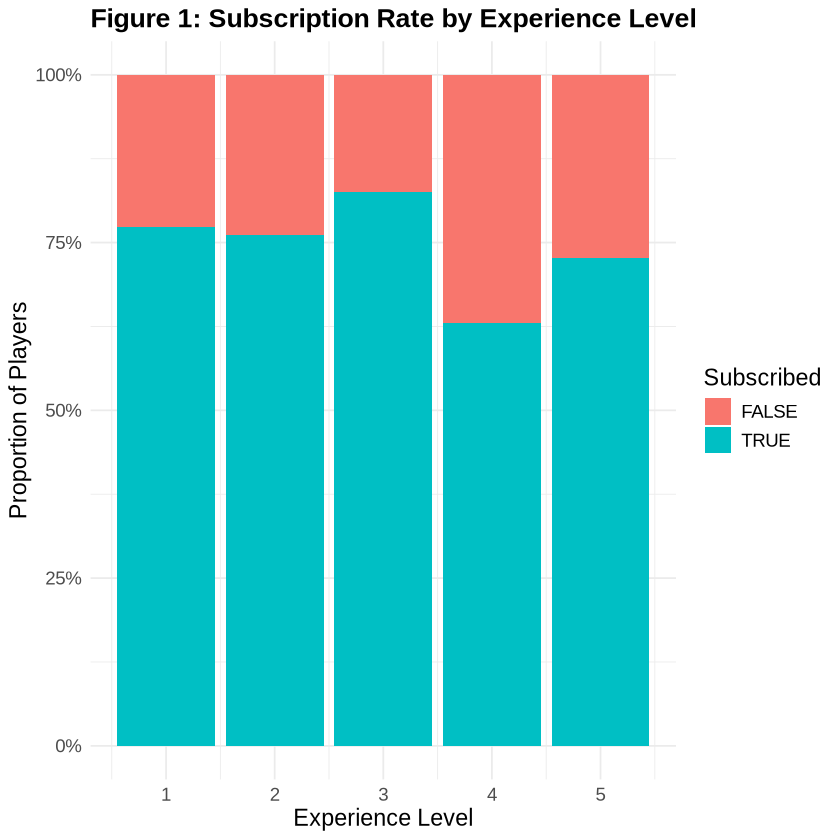

In [ ]:
# Plot subscription rate by experience level (proportion bar plot)
ggplot(model_data_clean, aes(x = experience_numeric, fill = subscribe)) + 
    geom_bar(position = "fill") +
    labs(
        title = "Figure 1: Subscription Rate by Experience Level",
        x = "Experience Level",
        y = "Proportion of Players",
        fill = "Subscribed"
    ) +
    scale_y_continuous(labels = scales::percent_format()) +
    theme_minimal() +
        theme( 
            text = element_text(size = 14),
            plot.title = element_text(size = 16, face = "bold")
    )

*Figure 1.* Proportion of players who subscribed to the newsletter within each experience level. The figure shows how subscription patterns vary across different levels of self reported experience.

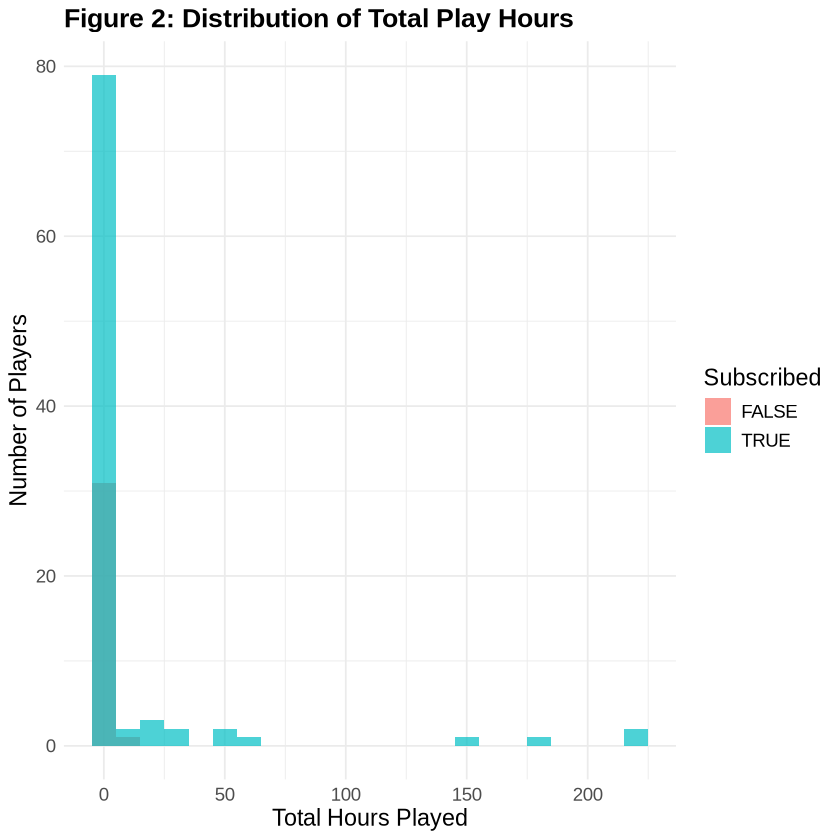

In [ ]:
# Plot distribution of play hours for subscribers vs non-subscribers
ggplot(model_data_clean, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(binwidth = 10, alpha = 0.7, position = "identity") +
    labs(
        title = "Figure 2: Distribution of Total Play Hours",
        x = "Total Hours Played",
        y = "Number of Players",
        fill = "Subscribed"
    ) +
    theme_minimal() +
        theme( 
            text = element_text(size = 14),
            plot.title = element_text(size = 16, face = "bold")
    )

*Figure 2.* Histogram showing the distribution of total playtime for subscribers and non-subscribers. This visual helps illustrate whether players with higher playtime tend to subscribe more often. Subscribers appear more often at higher playtime values, suggesting a relationship between engagement and subscription.

### 2.5 Data Analysis: KNN Classification Model   

To answer our main question about predicting newsletter subscription, we fit a k-nearest neighbours (KNN) classification model using the `tidymodels` framework.   

Our outcome variable is:  

- `subscribe` (TRUE/FALSE)

Our predictor variables are:   

- `experience` (an ordinal numeric version of the experience level),
- `played_hours` (total hours played),
- `total_sessions` (total number of sessions).

We follow these steps:   

1. Split the cleaned data into training (75%) and test (25%) sets, stratified by `subscribe`.
2. Create a recipe that standardizes the numeric predictors (`played_hours`, `total_sessions`) using centering and scaling.
3. Specify a KNN model with a tunable `neighbors` parameter.
4. Use 5-fold cross-validation on the training set to tune `neighbors` from 1 to 15.
5. Select the best `k` based on classification accuracy.
6. Fit the final model with this `k` and evaluate it on the test set.

In [ ]:
#Set seed for reproducibility 
set.seed(123)

#Split the cleaned dataset into training (75%) and testing (25%)
data_split <- initial_split(model_data_clean, prop = 0.75, strata = subscribe)

#Create training and testing sets
train_data <- training(data_split)
test_data <- testing(data_split)

In [ ]:
# Create a recipe that:
# - converts experience_numeric into a numeric predictor 
# - scales and centers all numeric predictors for KNN
recipe_knn <- recipe(subscribe ~ experience_numeric + played_hours + total_sessions,
                     data = train_data) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors())

In [ ]:
# Specify a KNN classifier with tunable number of neighbours (k)
knn_spec <- nearest_neighbor(
    neighbors = tune(),
    weight_func = "rectangular"
) |>
    set_engine("kknn") |>
    set_mode("classification")

# Set up to 5 folds cross-validation
cv_folds <- vfold_cv(train_data, v = 5, strata = subscribe)

# Create a grid of k values to tune over (1 to 15)
k_grid <- tibble(neighbors = 1:15)

In [ ]:
# Create workflow combining recipe and model
knn_workflow <- workflow() |>
    add_recipe(recipe_knn) |>
    add_model(knn_spec)

# Tune k using cross-validation
knn_results <- knn_workflow |>
    tune_grid(
        resamples = cv_folds,
        grid = k_grid
    )

### 2.6 Visualizing And Evaluating The Analysis   

We first visualize how cross-validated accuracy changes with the number of neighbours (k), and then we select the best k and evaluate the final model on the test set.   

#### 2.6.1 Accuracy Across Different Values of k

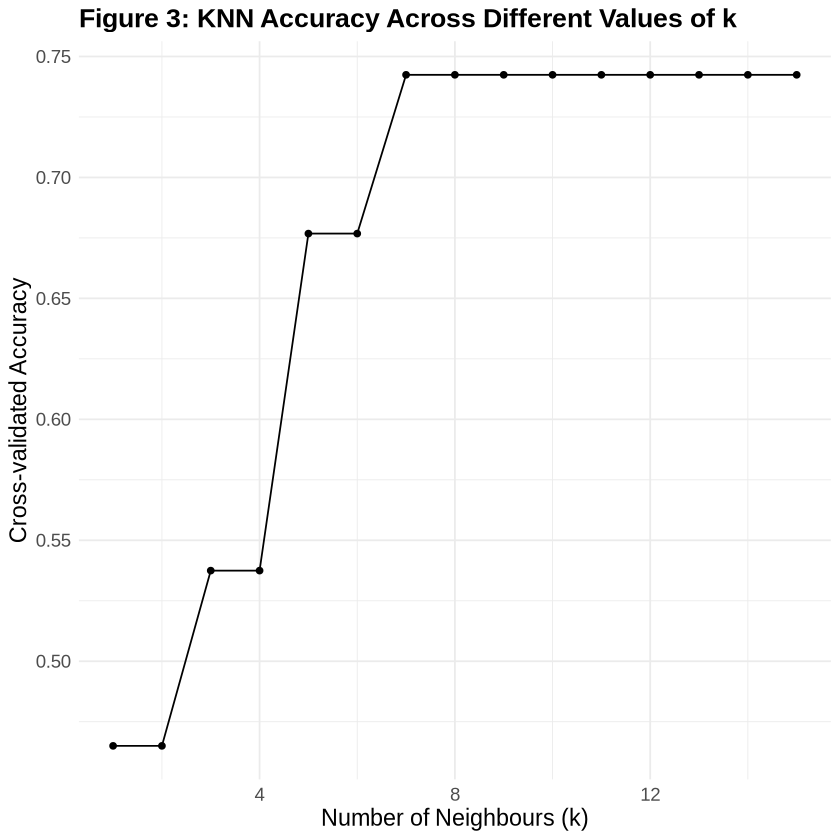

In [ ]:
# Extract accuracy values from tuning results for plotting
accuracy_results <- knn_results |>
  collect_metrics() |>
  filter(.metric == "accuracy")

# Plot accuracy across different values of k
ggplot(accuracy_results, aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(
        title = "Figure 3: KNN Accuracy Across Different Values of k",
        x = "Number of Neighbours (k)",
        y = "Cross-validated Accuracy"
    ) +
theme_minimal() +
        theme( 
            text = element_text(size = 14),
            plot.title = element_text(size = 16, face = "bold")
    )

*Figure 3.* Cross-validated classification accuracy for different values of k in the KNN model. We use this plot and the corresponding table to select the value of k that performs best.

#### 2.6.2 Final Model And Test-set Performance   

We now selcect the k value that maximizes accuracy, fit a final KNN model model using this k on the full training set, and evaluate it on the test set. We report accuracy and examine a confusion matric to understand what kinds of errors the model makes.

In [ ]:
# Select best k based on accuracy
best_k <- knn_results |>
    select_best(metric = "accuracy")

best_k

neighbors,.config
<int>,<chr>
7,Preprocessor1_Model07


In [ ]:
# Finalize and fit the best performing model
final_knn <- finalize_model(knn_spec, best_k)

final_workflow <- workflow() |>
    add_recipe(recipe_knn) |>
    add_model(final_knn)

final_fit <- final_workflow |>
    fit(data = train_data)

In [ ]:
# Generate predictions on the test dataset
predictions <- predict(final_fit, test_data) |>
    bind_cols(test_data)

# Calculate accuracy and other classification metrics
subscription_metrics <- metrics(predictions, truth = subscribe, estimate = .pred_class)
subscription_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71875000
kap,binary,0.05263158


In [ ]:
# Create a confusion matric to evaluate prediction performance 
confusion_matrix <- conf_mat(predictions, truth = subscribe, estimate = .pred_class)
confusion_matrix

          Truth
Prediction FALSE TRUE
     FALSE     1    2
     TRUE      7   22

In [ ]:
# Calculate additional classification metrics: precision and recall
subscription_metrics_full <- metric_set(accuracy, kap, precision, recall)

metrics_results <- subscription_metrics_full(
    predictions, 
    truth = subscribe,
    estimate = .pred_class
)

metrics_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71875000
kap,binary,0.05263158
precision,binary,0.33333333
recall,binary,0.12500000


In addition to accuracy and kappa, we comute precision and recall for the "subscribed" class (subscribe = TRUE). Precision measures, among all players the model predicts as subscribers, how many actually subscribed. Recall measures, among all true subscribers, how many the model correctly identifies.

Based on the confusion matrix, the model's precision for subscribers is about 0.33, meaning that when it predicts a player has subscribed, this is correct roughly three-quarters of the time. The recall is lower, around 0.13, indicating that the model correctly identifies only a small proportion of true subscribers.

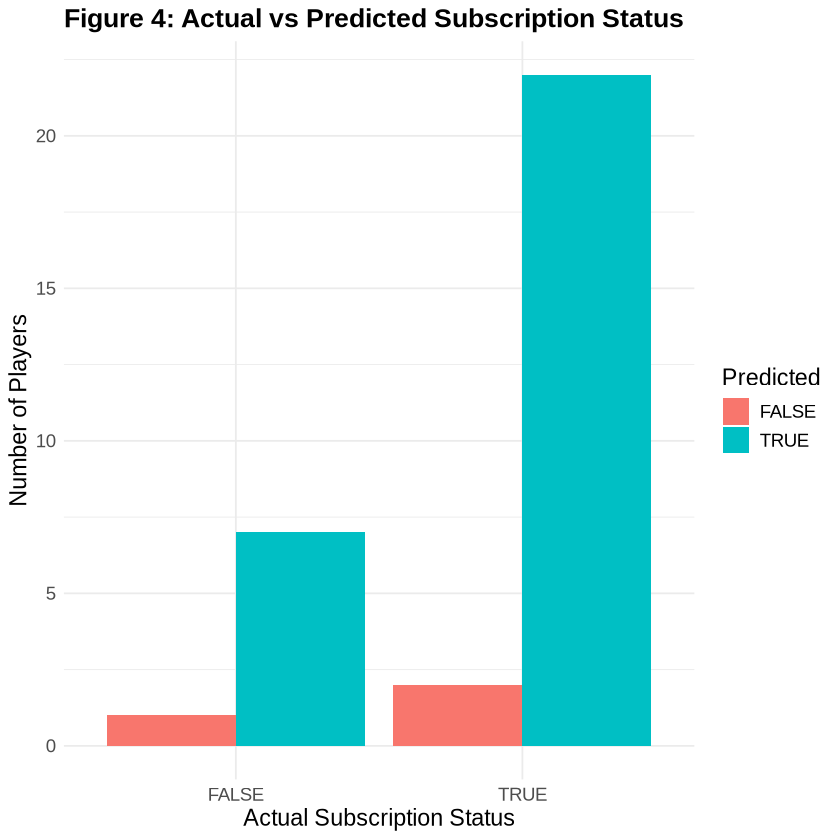

In [ ]:
# Plot actual vs predicted subcription classifications

ggplot(predictions, aes(x = subscribe, fill = .pred_class)) +
    geom_bar(position = "dodge") +
    labs(
        title = "Figure 4: Actual vs Predicted Subscription Status",
        x = "Actual Subscription Status",
        y = "Number of Players",
        fill = "Predicted"
    ) +
theme_minimal() +
        theme( 
            text = element_text(size = 14),
            plot.title = element_text(size = 16, face = "bold")
    )

*Figure 4.* Bar plot comparing actual subscription status to the model's predictions on the test set. This helps visualize whether the model correctly identifies both subscribers and non-subscribers.

## 3. Discussion